In [1]:
# Import necessary packages
import numpy as np
import matplotlib.pyplot as plt
import utility
from rectangle import Rectangle
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
import pandas as pd
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Data generation

In [2]:
# 2-dim data, n=500
X0, y0 = make_regression(n_samples=500, n_features=20, n_informative= 15, noise= 20, n_targets=2, random_state=88)

# Add random noise to one of the targets
np.random.seed(650)
np.transpose(y0)[:1]+= np.random.randn(500)*20

# Train, calibration, and test split, default ratio: 80/10/10
X0_train, X0_test, X0_cal, y0_train, y0_test, y0_cal = utility.calibration_split(X0, y0)

# Fit model to training
model0 = LinearRegression()
model0.fit(X0_train, y0_train)

# Vectorized calibration scores
prediction0 = model0.predict(X0_cal)
scores0 = np.abs(prediction0 - y0_cal)

# Test scores
prediction_test0 = model0.predict(X0_test)
scores_test0 = np.abs(prediction_test0 - y0_test)

In [32]:
def graphing_tools_2D(ax, scores, regions = None, regions_color = "#fca3a3", rectangle = None, rectangle_fill_color = None, rectangle_boundary_color = None, label = None):

    scores_transpose = np.transpose(scores)
    ax.scatter(scores_transpose[0], scores_transpose[1], color = "#1f77b4", s = 2, zorder=10)

    if rectangle:
        rectangle.draw_2D(ax, fill_color = rectangle_fill_color, boundary_color = rectangle_boundary_color, transparancy = 0.5)
    if regions:
        for region in regions:
            region.draw_2D(ax, boundary_color = None, fill_color = regions_color, transparancy = 0.5)

    # Set up aesthetics
    limits = np.max(scores, axis = 0)*1.05
    ax.set_xlim(0, limits[0])
    ax.set_ylim(0, limits[1])
    ax.set_aspect('equal', adjustable = "box")
    if label: 
        ax.set_xlabel(f"Dimension {label[0]}")
        ax.set_ylabel(f"Dimension {label[1]}")
    else:
        ax.set_xlabel(f"Dimension 0")
        ax.set_ylabel(f"Dimension 1")
    plt.tight_layout()
    


# Illustrations generation

## No scaling rectangular prediction region (NRPR)

In [23]:
scores_sup = np.max(scores0, axis=1)

import math
threshold0 = math.ceil((len(scores_sup)+1)*0.8)
scores0_quantile = np.sort(scores_sup, kind="mergesort")[threshold0]

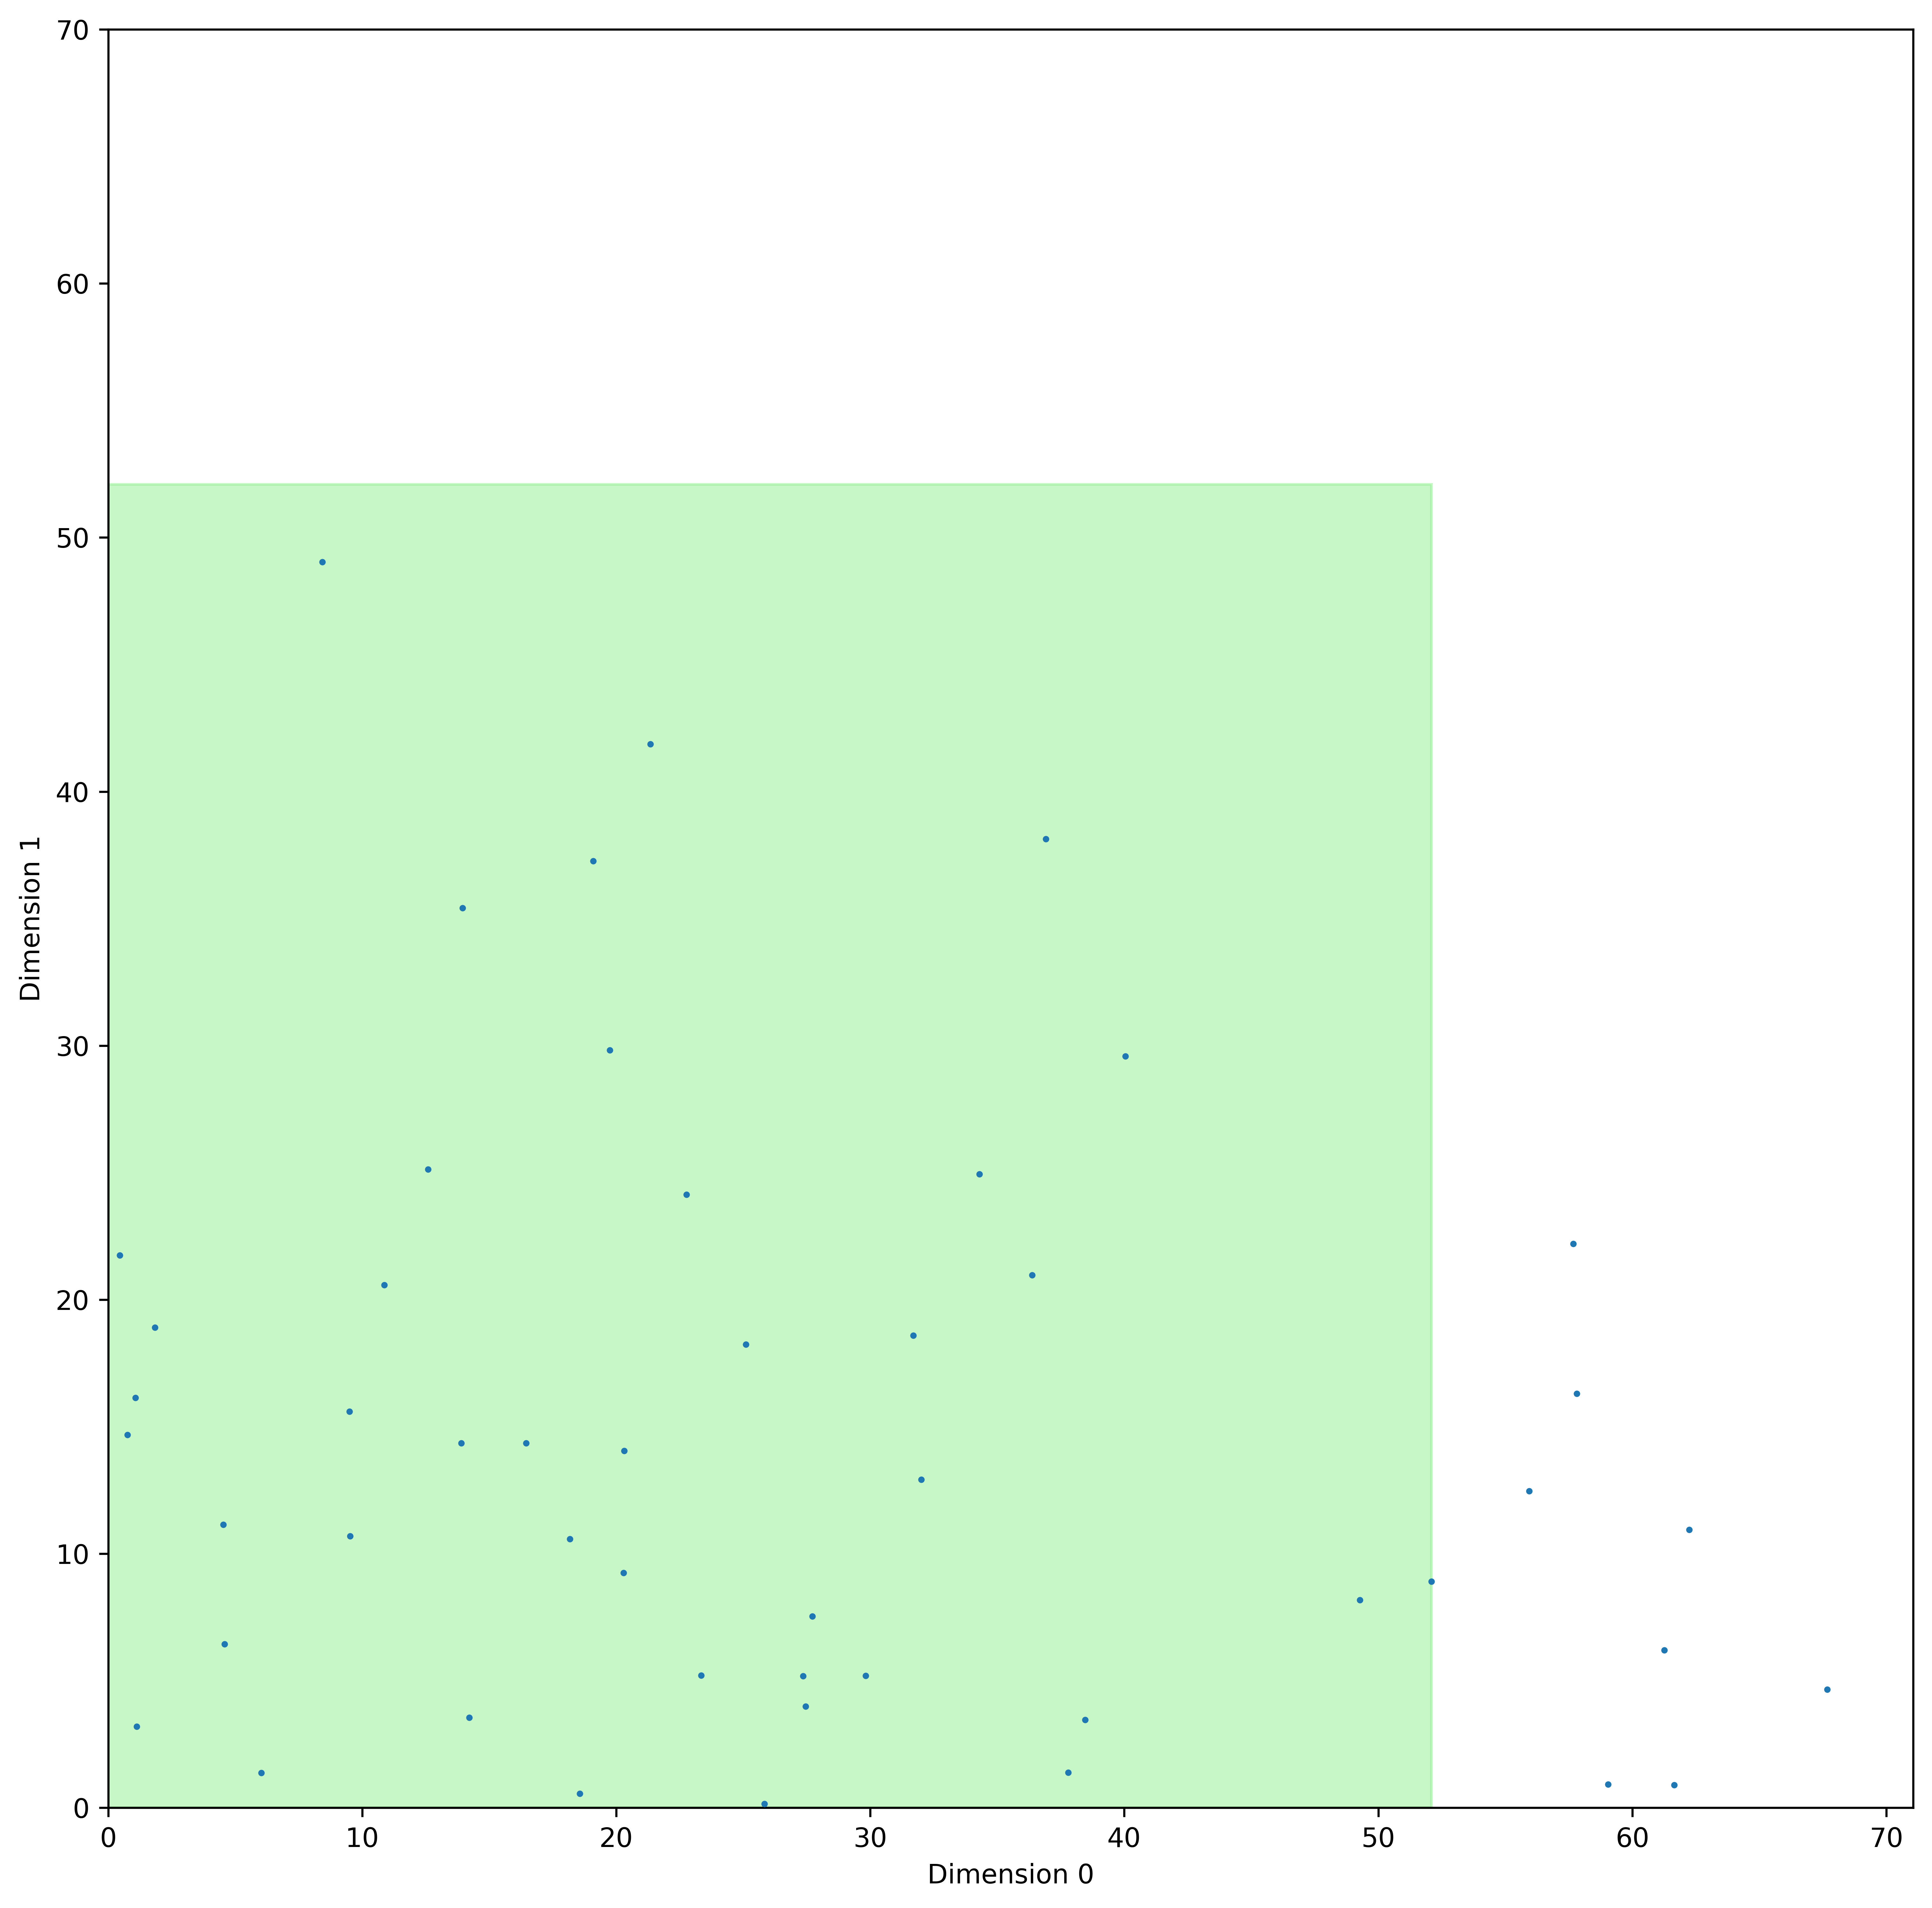

In [37]:
fig, ax = plt.subplots(1, 1, figsize = (15, 10), dpi = 600)
graphing_tools_2D(ax, scores0, rectangle=Rectangle(upper=(scores0_quantile, scores0_quantile)), rectangle_fill_color="lightgreen")
ax.set_ylim(0, 70)
plt.show()

fig.savefig("illustrations_in_paper/no_scaling_prediction_region.pdf", dpi=600)

## Localized rectangular prediction region (LRPR)

In [16]:
full_regions0, full_region_max_rect0 = utility.one_rect_prediction_regions_nD(scores0, 0.2, False)

In [17]:
region0 = utility.one_rect_prediction_regions_nD(scores0, 0.2, True)

In [ ]:
def make_2D_score_plot(scores, dimx, dimy, ax = None, figsize=(8, 8), limits = None):
    """
    Create a 2D scatter plot for a specific pair of dimensions.

    Parameters
    ----------
    scores : numpy.ndarray
        Matrix of shape (n_samples, n_features) representing the data to plot.
    dimx : int
        Index of the dimension for the x-axis.
    dimy : int
        Index of the dimension for the y-axis.
    figsize : tuple, optional
        Size of the figure in inches. Default: (8, 8).

    Returns
    -------
    tuple
        fig, ax : matplotlib Figure and Axes object.
    """

    n = scores.shape[1]
    if not (0 <= dimx < n and 0 <= dimy < n):
        raise ValueError(f"dimx={dimx} or dimy={dimy} out of range for {n}-dimensional data.")
    if dimx == dimy:
        raise ValueError("dimx and dimy must be different to form a valid 2D projection.")

    scores_transpose = np.transpose(scores)
    if limits is None:
        limits = np.max(scores[:, [dimx, dimy]], axis = 0)*1.1

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        ax.scatter(scores_transpose[dimx], scores_transpose[dimy], s=1)
        ax.set_xlim(0, limits[0])
        ax.set_ylim(0, limits[1])
        ax.set_aspect('equal', adjustable = "box")
        ax.set_xlabel(f"Dimension {dimx}")
        ax.set_ylabel(f"Dimension {dimy}")
        ax.set_title(f"Projection on dims ({dimx}, {dimy})")
        plt.tight_layout()
        return fig, ax
    
    ax.scatter(scores_transpose[dimx], scores_transpose[dimy], s=1)
    ax.set_xlim(0, limits[0])
    ax.set_ylim(0, limits[1])
    ax.set_aspect('equal')
    ax.set_xlabel(f"Dimension {dimx}")
    ax.set_ylabel(f"Dimension {dimy}")
    ax.set_title(f"Projection on dims ({dimx}, {dimy})")
    plt.tight_layout()

def make_score_plot(scores, global_limit = True):
    """
    Create scatter plots of pairwise dimensions of vectorized scores.

    Parameters
    ----------
    scores : numpy.ndarray
        Matrix of shape (n_samples, n_features) representing the data to plot.
    dimx : int, optional
        Index of the dimension for the x-axis. Default: None (all pairs).
    dimy : int, optional
        Index of the dimension for the y-axis. Default: None (all pairs).
    figsize : tuple, optional
        Size of the figure in inches. Default: (12, 12).

    Returns
    -------
    tuple
        fig, axes : matplotlib Figure and Axes object(s).
    """

    n = scores.shape[1]
    # All pairwise projections
    dim_pairs = list(combinations(range(n), 2))  # Unique pairs of dimensions
    num_pairs = len(dim_pairs)

    # Determine grid layout
    cols = min(3, num_pairs)
    rows = math.ceil(num_pairs / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows), squeeze=False)
    axes = axes.flatten()  # Flatten for easy iteration

    for idx, (dx, dy) in enumerate(dim_pairs):
        if global_limit:
            global_limits = [np.max(scores) * 1.1, np.max(scores) * 1.1]
            make_2D_score_plot(scores, dx, dy, axes[idx], limits = global_limits)
        else:
            make_2D_score_plot(scores, dx, dy, axes[idx])

    # Hide unused subplots
    for idx in range(num_pairs, len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    return fig, axes

## Comparison between LRPR and NRPR

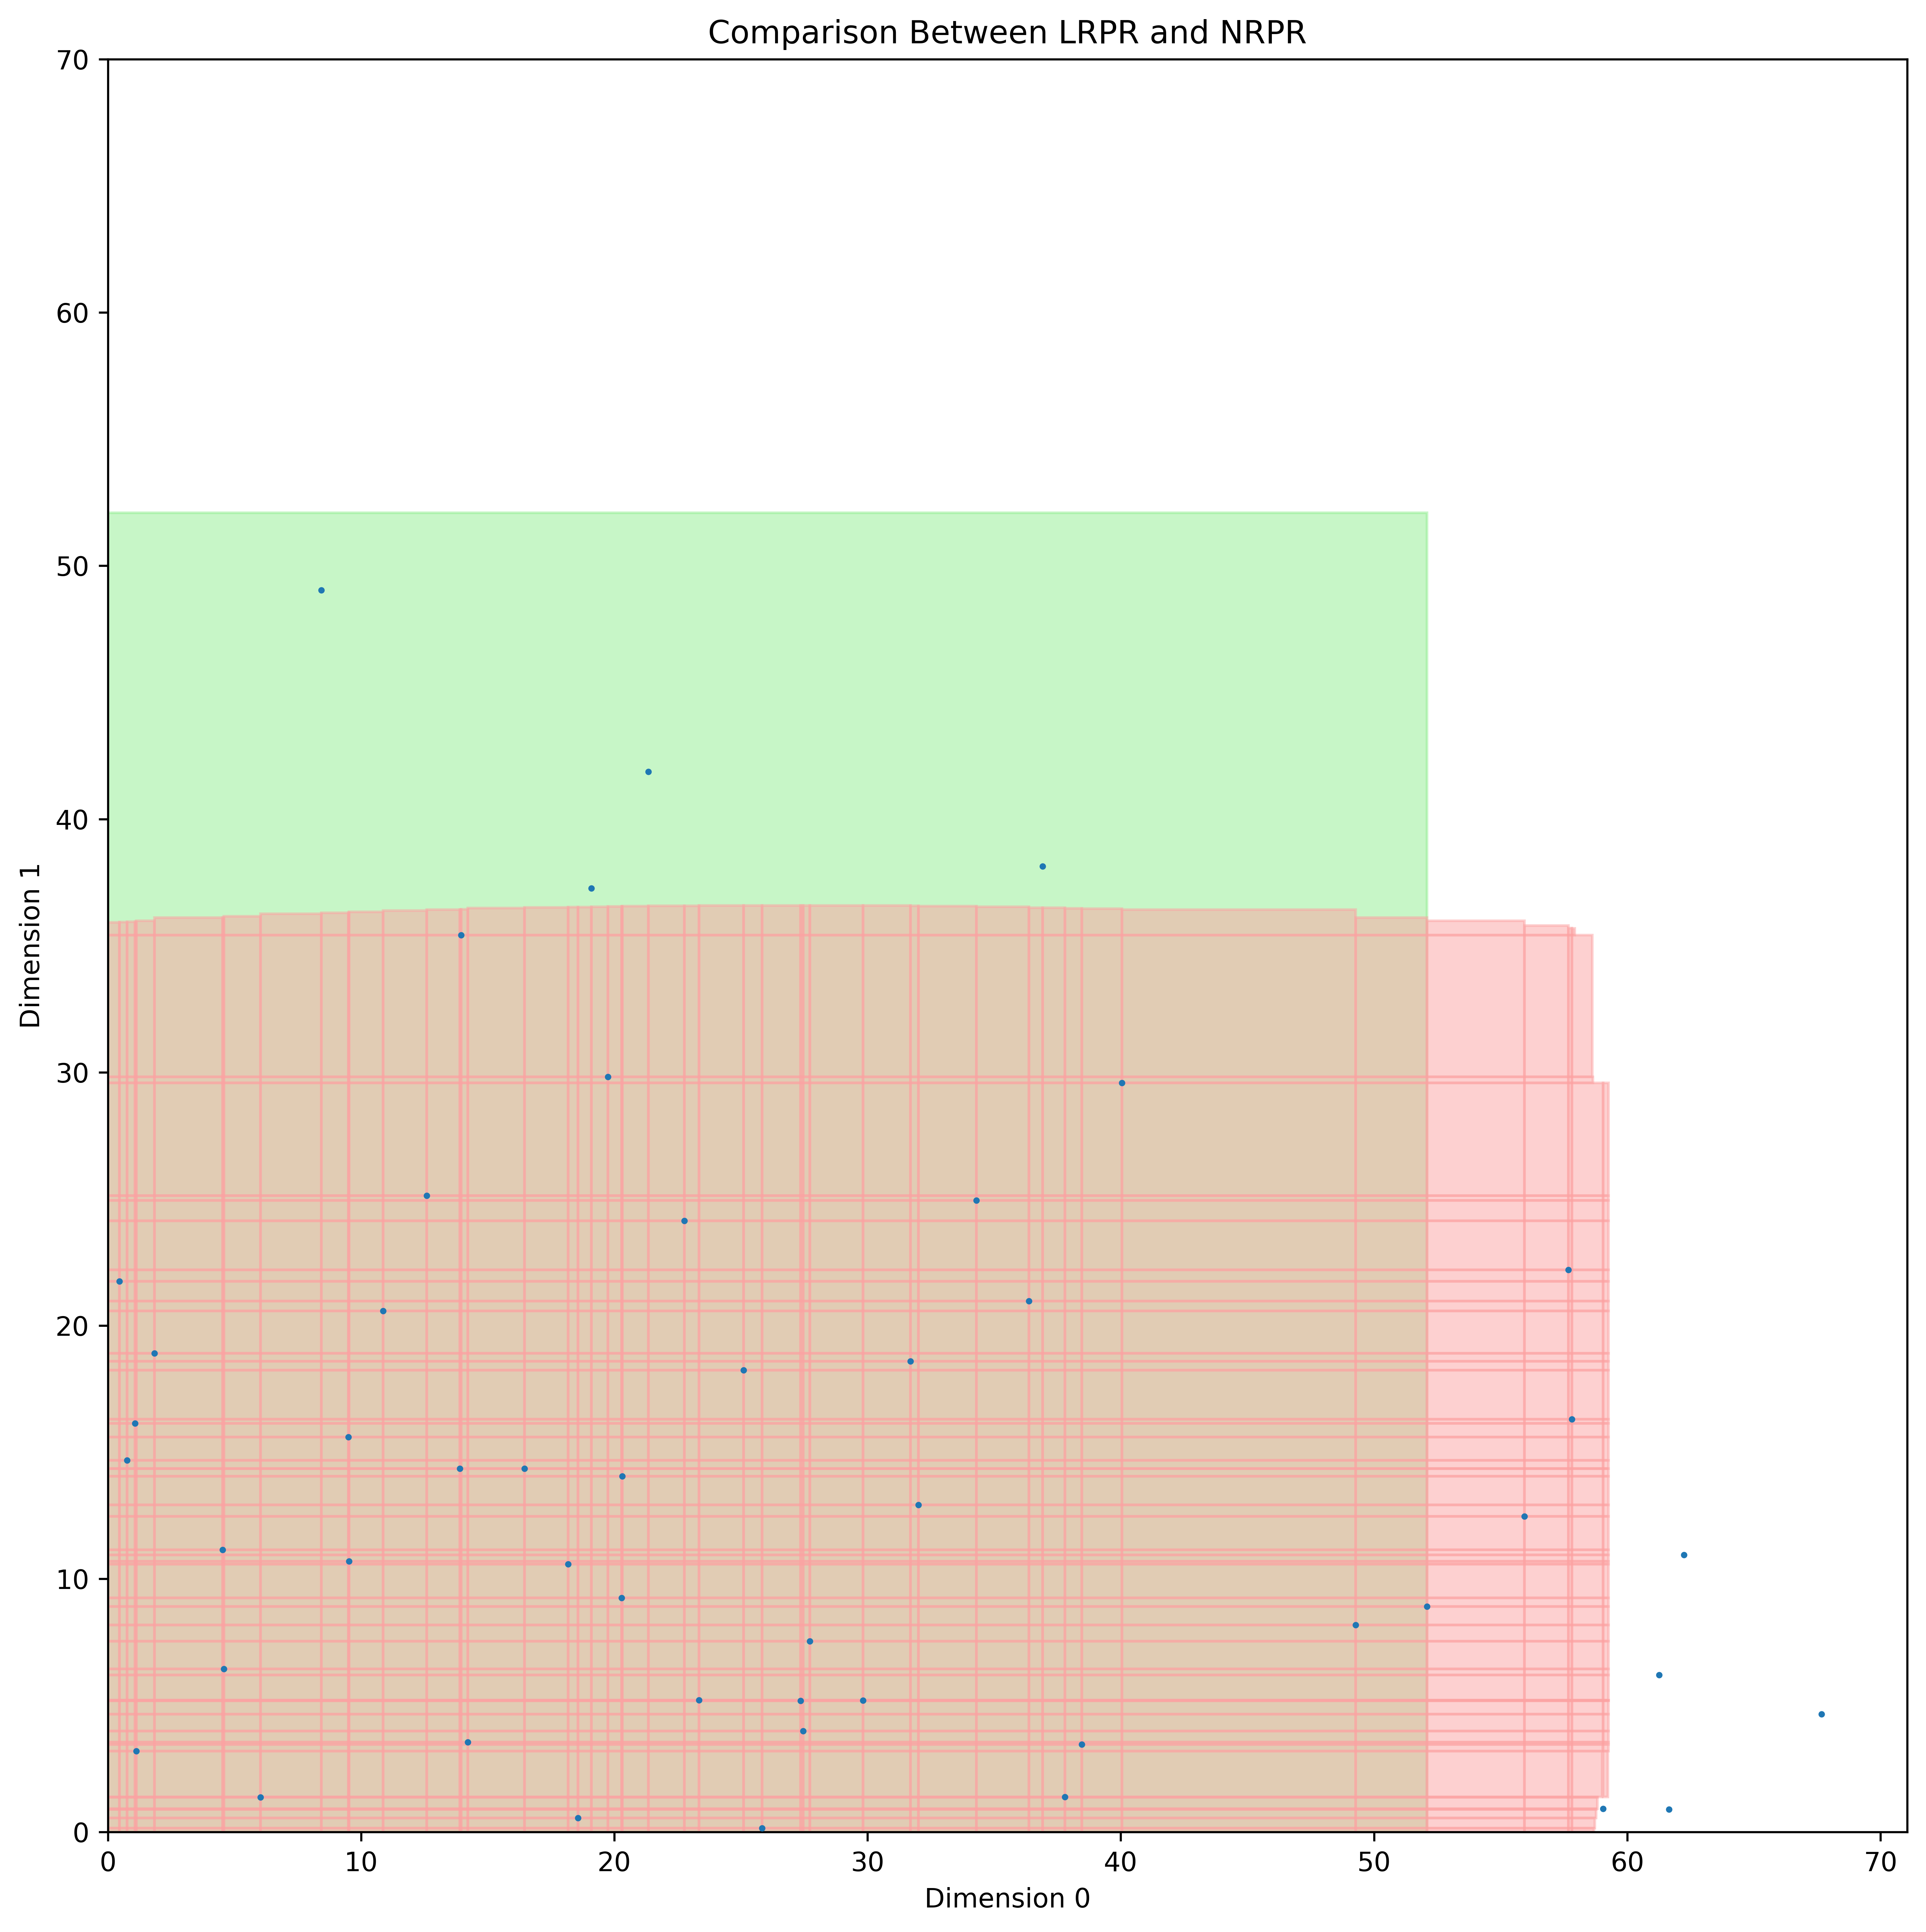

In [36]:
fig, ax = plt.subplots(1, 1, figsize = (15, 10), dpi = 600)
graphing_tools_2D(ax, scores0, regions= full_regions0, rectangle=Rectangle(upper=(scores0_quantile, scores0_quantile)), rectangle_fill_color="lightgreen")
ax.set_ylim(0, 70)
ax.set_title("Comparison Between LRPR and NRPR")
plt.show()

fig.savefig("illustrations_in_paper/comparison_between_LRPR_and_NRPR.pdf", dpi=600)

In [18]:
fig, axes = plt.subplots(1, 2, figsize = (30, 10), dpi=600)

for ax in axes:
    graphing_tools_2D(ax, scores0, regions = full_regions0)
    ax.set_title("Full Prediction Region In The Score Space")

    score_legend = Line2D([0], [0], marker='o', color='w', label='Calibration Scores',
                        markerfacecolor="#1f77b4", markersize=5)
    region_legend = Patch(facecolor="#fca3a3", edgecolor='none', label="Localized Prediction Regions")
    ax.legend(handles=[region_legend, score_legend], loc="upper right", fontsize=10)

region0.draw_2D(axes[1], boundary_color="Black", fill_color=None)
axes[1].annotate(
    "Final Prediction Region (Short cut)",
    xy=(region0.upper[0], region0.upper[1]),          # corner of the box
    xytext=(region0.upper[0] - 5, region0.upper[1] +3),  # text offset
    textcoords='data',
    arrowprops=dict(arrowstyle="->", color="black"),
    fontsize=10,
    color="black",
    ha='left'
)

plt.show()

fig.savefig("illustrations_in_paper/prediction_regions_illustration.pdf", dpi=600, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (12, 12), dpi=600)
graphing_tools_2D(ax, scores0, regions = full_regions0)
ax.set_title("Global Prediction Region In The Score Space")
plt.show()

fig.savefig("illustrations_in_paper/prediction_regions_illustration.pdf", dpi=600, bbox_inches='tight')

# Illustration of short cut

In [19]:
region0 = utility.one_rect_prediction_regions_nD(scores0, 0.2, True)

In [20]:
mean_index0 = utility.mean_index_solver(scores0)
col_base = [np.sort(scores0, axis = 0)[mean_index0[0]][0], np.sort(scores0, axis = 0)[mean_index0[0]+1][0]]
row_base = [np.sort(scores0, axis = 0)[mean_index0[1]][1], np.sort(scores0, axis = 0)[mean_index0[1]+1][1]]

In [21]:
col_rect = Rectangle(upper=[col_base[1], region0.upper[1]], lower=[col_base[0], 0])
row_rect = Rectangle(upper=[region0.upper[0], row_base[1]], lower=[0, row_base[0]])

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(30, 10), dpi=600)

# Shared style options
highlight_color = "#006400"     # Dark green
grid_color = "#fca3a3"          # Light red
arrow_style = dict(arrowstyle="->", color='black', lw=1.2)

# ──────────────── 1️⃣ Vertical Search ────────────────
graphing_tools_2D(
    axes[0], scores0,
    regions=full_regions0,
    regions_color=grid_color
)

col_rect.draw_2D(
    axes[0],
    boundary_color=None,
    fill_color=highlight_color,
    transparancy=0.8
)

axes[0].axhline(region0.upper[1], color="black", linestyle="--", lw = 1)
axes[0].set_title(
    "Vertical search: identifying top boundary (short-cut)",
    fontsize=14, fontweight='bold'
)

axes[0].annotate(
    "Top boundary",
    xy=(col_base[1], region0.upper[1]),
    xytext=(col_base[1], region0.upper[1] + 8),
    arrowprops=arrow_style,
    fontsize=12, ha='center'
)

# ──────────────── 2️⃣ Horizontal Search ────────────────
graphing_tools_2D(
    axes[1], scores0,
    regions=full_regions0,
    regions_color=grid_color
)

row_rect.draw_2D(
    axes[1],
    boundary_color=None,
    fill_color=highlight_color,
    transparancy=0.8
)

axes[1].axvline(region0.upper[0], color="black", linestyle="--", lw = 1)
axes[1].set_title(
    "Horizontal search: identifying right boundary (short-cut)",
    fontsize=14, fontweight='bold'
)

axes[1].annotate(
    "Right boundary",
    xy=(region0.upper[0], row_base[1]),
    xytext=(region0.upper[0] + 3, row_base[1] + 5),
    arrowprops=arrow_style,
    fontsize=12, ha='left'
)

plt.tight_layout()
plt.show()

fig.savefig("illustrations_in_paper/short_cut_visualization.pdf", dpi=600, bbox_inches='tight')